In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, Model

In [2]:
# Data
train_csv = '/content/sign_mnist_train.csv'
test_csv = '/content/sign_mnist_test.csv'

categories = 26

# Settings
input_tensor = tf.keras.Input(shape=(28, 28, 3))

# Train settings
batch_size=32
epochs=50

### Load Data

In [3]:
# Load with pandas (more simple)
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [4]:
# Select labels
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [5]:
# Select features
x_train = train_df.values
x_test = test_df.values

In [6]:
# Reshape features to images
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [7]:
x_train = np.concatenate([x_train] * 3, axis=-1)
x_test = np.concatenate([x_test] * 3, axis=-1)

In [8]:
# train_dataset = tf.data.experimental.make_csv_dataset(
#     train_csv,
#     batch_size,
#     label_name='label'
# )

In [9]:
# def preprocess_data(feats, label):
#   print(feats.values())
#   images = tf.concat(feats.values(), 1)
#   print(images)
#   return images, label

# train_dataset = train_dataset.map(preprocess_data)

In [10]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [11]:
print(x_train.shape)
print(x_test.shape)

(27455, 28, 28, 3)
(7172, 28, 28, 3)


### Pre-process data

In [12]:
# As categorical
y_train = tf.keras.utils.to_categorical(y_train, categories)
y_test = tf.keras.utils.to_categorical(y_test, categories)

In [13]:
# Load as tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [14]:
def preprocess_data(image, label):
  image_p = tf.keras.applications.resnet50.preprocess_input(image)
  # label_p = tf.keras.utils.to_categorical(label, 10)
  return image_p, label

In [15]:
train_dataset = train_dataset.map(preprocess_data).shuffle(1000).batch(batch_size)
test_dataset = test_dataset.map(preprocess_data).batch(batch_size)

### Load Model

In [16]:
feature_extractor = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)

In [17]:
# Freeze all layers
# feature_extractor.trainable = False

In [18]:
# Freeze layers exept last block
for layer in feature_extractor.layers[:143]:
  layer.trainable = False

### Make Model

In [19]:
model = tf.keras.models.Sequential()

In [20]:
# # Data augmentation
# data_augment = tf.keras.models.Sequential([
#     layers.RandomRotation(0.1, seed=42),
#     layers.RandomTranslation(0.1, 0.1, seed=42),
#     layers.RandomZoom(0.1, seed=42)
#     # layers.RandomFlip(seed=42)
# ])

# data_augment.build(input_shape=input_tensor.shape[1:])

# model.add(data_augment)

In [21]:
# Feature extraction
model.add(feature_extractor)

# Classification
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(categories, activation='softmax'))

In [22]:
# model.build(input_shape=input_tensor.shape)

### Compile and Fit

In [23]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 26)                53274     
                                                                 
Total params: 23640986 (90.18 MB)
Trainable params: 15029274 (57.33 MB)
Non-trainable params: 8611712 (32.85 MB)
_________________________________________________________________


In [24]:
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [25]:
run_hist = model.fit(train_dataset, batch_size=batch_size, epochs=epochs,
                    validation_data=test_dataset, callbacks=[save_model])

Epoch 1/50
858/858 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.9487
Epoch 1: val_accuracy improved from -inf to 0.94186, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


858/858 [==============================] - 38s 33ms/step - loss: 0.3272 - accuracy: 0.9487 - val_loss: 0.2110 - val_accuracy: 0.9419
Epoch 2/50
856/858 [============================>.] - ETA: 0s - loss: 0.0577 - accuracy: 0.9953
Epoch 2: val_accuracy improved from 0.94186 to 0.95148, saving model to model.h5
858/858 [==============================] - 24s 28ms/step - loss: 0.0578 - accuracy: 0.9953 - val_loss: 0.2124 - val_accuracy: 0.9515
Epoch 3/50
857/858 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9970
Epoch 3: val_accuracy improved from 0.95148 to 0.95664, saving model to model.h5
858/858 [==============================] - 25s 29ms/step - loss: 0.0315 - accuracy: 0.9970 - val_loss: 0.2227 - val_accuracy: 0.9566
Epoch 4/50
857/858 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9983
Epoch 4: val_accuracy improved from 0.95664 to 0.95747, saving model to model.h5
858/858 [==============================] - 26s 30ms/step - loss: 0.013

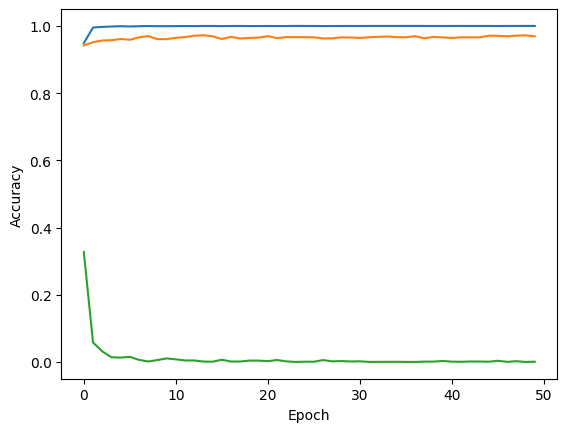

In [26]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.plot(run_hist.history['accuracy'], label='train')
plt.plot(run_hist.history['val_accuracy'], label='test')
plt.plot(run_hist.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()